In [1]:
import os                         # For operating system
#import re                         # Regular expression 
import cv2                        # Image processing 
#import glob                       # Unix style pathname pattern expansion
import numpy as np                # linear algebra 
import random                     # For random number generation 
import shutil                     # High-level file operations
#import requests                   # Reading url 
#from PIL import Image             # Python Image Library 
#from bs4 import BeautifulSoup     # Web scrapping 
#from PIL import Image             # Python image library 
import matplotlib.pyplot as plt   # Making plots 
import matplotlib.image as mpimg  # To view color image 
import matplotlib.pyplot as plt               # making plots
from IPython.display import display           # displaying ?
import warnings                               # ignoring unnecessary python warnings 
warnings.filterwarnings('ignore')

from keras.applications.vgg16 import VGG16                   # pretrained CNN                        
from keras.callbacks import ModelCheckpoint                  # furter train the saved model 
from tensorflow.keras  import models, layers, optimizers     # building DNN is keras 
from tensorflow.keras.models import load_model               # load saved model 
from keras.preprocessing.image import ImageDataGenerator     # preparing image data for training 
%matplotlib inline

# Loading dataset


#### Preparing directories and path 

In [2]:
# Base directroy where dataset is stored locally 
base_dir = 'C:/Users/decim/OneDrive/Desktop//Fire Detection Model master/A/Dataset'
# Base directroy where dataset is stored locally 
dst_fire='C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/A/Dataset/Fire'
dst_nofire='C:/Users/decim/OneDrive/Desktop//Fire Detection Model master/A/Dataset/Nofire'

#### Shuffling and re-naming images 

And finally, we want to shuffle the files in the final destination and rename them appropriately. Shuffling is necessary because we are going to separate the files in the train and test set and shuffling makes the separation more representative. 

In [3]:
def file_rename(path, name, n_shuffle=10):
    
    '''This functions renames all the .jpg 
    files in path in name.#.jpg format. 
    name should be passed as string. 
    Files are shuffled before renaming. 
    n_shuffle is number of times you shuffle
    the files.'''
    
    files = os.listdir(path)
    
    for _ in range(n_shuffle):
        random.shuffle(files)
    
    for index, file in enumerate(files):
        src = os.path.join(path, file)
        dst = os.path.join(path, \
                ''.join([name,'.', str(index + 1), '.jpg']))
        os.rename(src, dst)

In [4]:
# Renaming files 
file_rename(dst_fire, 'fire', n_shuffle=100)
file_rename(dst_nofire, 'nofire', n_shuffle=100)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/A/Dataset/Fire\\fire.39.jpg' -> 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/A/Dataset/Fire\\fire.1.jpg'

# Train and test set



Next, we separate the training and test data. I will take three-quarter of images from each category as a training set and one-quarter images from each as a test set. 


##### Making train and test directory 

In [5]:
# make train directories 
train_dir = os.path.join(base_dir, 'train')

train_dir_fire = os.path.join(train_dir, 'fire')
if not os.path.exists(train_dir_fire):
    os.makedirs(train_dir_fire)
    
train_dir_nofire = os.path.join(train_dir, 'nofire')
if not os.path.exists(train_dir_nofire):
    os.makedirs(train_dir_nofire)

# make test directories 
test_dir = os.path.join(base_dir, 'test')

test_dir_fire = os.path.join(test_dir, 'fire')
if not os.path.exists(test_dir_fire):
    os.makedirs(test_dir_fire)
    
test_dir_nofire = os.path.join(test_dir, 'nofire')
if not os.path.exists(test_dir_nofire):
    os.makedirs(test_dir_nofire)

#### Copying files to the train and test directories 

In [6]:
def copy_file(src_path, dst_path, shuffle=False, no_modify=True, \
              start_index=None, end_index=None):
    
    '''This function copies files from src_path to dst_path.
    It copies files from start_index to end_index.
    shuffling can be activated to copy random files
    rather than first in the list.
    If modify=True, This function converts images to 
    RGB format and .jpg type before copying if they 
    are not already.'''
    
    # All files in src_path
    src_files = os.listdir(src_path)
    
    # Shuffle files before copying 
    if shuffle==True:
        for _ in range(10):
            random.shuffle(src_files)
    
    # Prepare directory to copy files 
    os.chdir(dst_path)
    
    # Copy from source to destination    
        
    for fname in src_files[start_index : end_index]:
        src = os.path.join(src_path, fname)
        
        if no_modify:
            dst = os.path.join(dst_path, fname)
            shutil.copyfile(src, dst)
  
        # option to change file format and extension etc.
        else:
            img = Image.open(src)  
            
            # Convert all images in RGB mode 
            if img.mode != 'RGB':
                # PIL cannot convert P to RGB directly. 
                if img.mode == 'P':    
                    img = img.convert('RGBA').convert('RGB')
                else: 
                    img = img.convert('RGB')

            # Convert all images in .jpg format 
            if fname.endswith('.jpg'):
                dst = os.path.join(dst_path, fname)
                shutil.copyfile(src, dst)
            else:
                fn, fext = os.path.splitext(fname)
                img.save('{}.jpg'.format(fn))

In [7]:
# Three-quarter is for training and one-quarter is for testing 
n_ = 3 * len(os.listdir(dst_fire)) // 4

# Copying train images 
copy_file(dst_fire, train_dir_fire, end_index=n_)
copy_file(dst_nofire, train_dir_nofire, end_index=n_)

# Copying test images 
copy_file(dst_fire, test_dir_fire, start_index=n_)
copy_file(dst_nofire, test_dir_nofire, start_index=n_)

# Data visualizations 

This function helps to visualize images in test and train set in various categories 


#### Function to present the images 

In [8]:
def image_collage(path, n_rows, n_cols, title):
    
    '''This function selects the first few images from given 
    path and presents in the collage form. 
    path is the directory from which images are taken. 
    n_rows and n_cols are rows and column of the collage. 
    title is the title of the collage.'''
    
    # Initiating the plot 
    fig = plt.figure()
    plt.title(title)
    
    # Turns off axis from the collage (total plot)
    plt.axis('Off')
    
    # List of all images in the path
    img_list = os.listdir(path)

    img_num = 1
    for img in img_list[:n_rows*n_cols]:
        
        # directroies of the choosen images 
        img_path = os.path.join(path, img)
        
        # showing the color images 
        img_read = mpimg.imread(img_path)

        # collage is formed from subplot
        ax = fig.add_subplot(n_rows, n_cols, img_num)
        img_num += 1
        
        # displaying image in subplot 
        ax.imshow(img_read)
        
        # turns off the axis from individual image in the collage
        ax.axis('Off')

#### Fire and non-fire images sample 

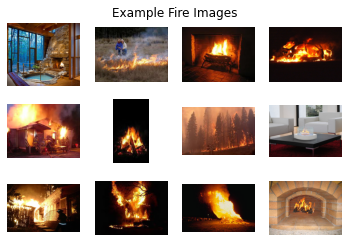

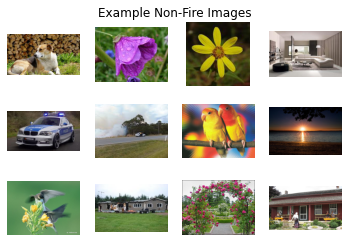

In [9]:
image_collage(train_dir_fire, 3, 4, 'Example Fire Images')
image_collage(train_dir_nofire, 3, 4, 'Example Non-Fire Images')

# Preparing the data 

In [10]:
train_dir = os.path.join(base_dir, 'train')
train_dir_fire = os.path.join(train_dir, 'fire')
train_dir_nofire = os.path.join(train_dir, 'nofire')

test_dir = os.path.join(base_dir, 'test')
test_dir_fire = os.path.join(test_dir, 'fire')
test_dir_nofire = os.path.join(test_dir, 'nofire')

#### Data generator & data augmentation 

For the large dataset it is not convenient to load all the data into memory. So we use image data generator to load the data from hard disc to memory in small batch. We do the same of the training and test set. 

Further, when initiating the image data generator we can do the data augmentation. This is the step to create more data from existing data by transforming the image. This artificially provides more data to train. Here we use rotation, translation, shear, zooming and horizontal flip for data augmentation. Other transformations like verticle flip is not suitable. We only do the data augmentation in the training set and not on the validation and test set. 

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                   target_size=(150, 150), 
                                                   batch_size=32,
                                                   class_mode='binary')

Found 104 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


# Model Architecture

I use VGG16 pretrained model. VGG-16 is a trained Convolutional Neural Network (CNN), from Visual Geometry Group (VGG), Department of Engineering Science, University of Oxford. The number 16 means the number of layers with trainable weights. The reference paper is here: 

https://arxiv.org/abs/1409.1556



A review article is here: 

https://neurohive.io/en/popular-networks/vgg16/


Pretrained model are trained in different data, not necessarily similar to the data we are training in this model. But we can still use it because of the follwing reason: The CNN has series of layers. Each layer learns a set of features from the image data. The lower layers learn fundamental patterns like edeges, lines, curves etc. The higher layers on the other hand are specific to the images on the model. Hence, the featured learned by the lower level can be general to the large class of images, even the images which model did not see during its training. Because of this reason we only use the base of the pre-trained model removing the top. We do this here in two steps. 

First, we retain all the base and remove only the dense top layer and train the model. Which gives us validation accuracy close to 95%. And in second step, we unlock the top convolutional model on the base and further train the model. Since we already have a decent accuracy we can imagine that the model is already close to the optimum model. So we only need to fine tune. For this reason we drop the learning rate to 10% of the previous case and train for larger number of iterations. Doing so we achieve a validation accuracy close to 99%. Which is pretty decent result. 

#### Setting up model 

We set the model with VGG16 base and custom top. 

- Loss: Since this is classification problem and there are two classes, we use the binary cross-entropy as the loss function. 

- Optimizer: We use RMSprop optimizer with customized learning rate. 

- Metrics: In addition to the loss we want to observe the accuracy. We optimize our model based on this metric.

In [12]:
conv_base = VGG16(weights='imagenet', 
                 include_top=False,
                 input_shape=(150, 150, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False

model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-4), 
             metrics=['acc'])

Here is the summary of the model. 

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# Training the model 

We pass the training data from the train_generator. We train for 30 epochs. We pass the validation data from the validation_generator.  We get validation accuracy above to 90% from this. 

In [14]:
history = model.fit(train_generator, epochs=30, 
                    validation_data=test_generator)

Epoch 1/30
4/4 [==============================] - 11s 3s/step - loss: 0.7361 - acc: 0.4519 - val_loss: 0.6328 - val_acc: 0.6389
Epoch 2/30
4/4 [==============================] - 10s 3s/step - loss: 0.5830 - acc: 0.6635 - val_loss: 0.5952 - val_acc: 0.6944
Epoch 3/30
4/4 [==============================] - 10s 2s/step - loss: 0.6118 - acc: 0.6827 - val_loss: 0.5447 - val_acc: 0.8056
Epoch 4/30
4/4 [==============================] - 10s 2s/step - loss: 0.4402 - acc: 0.8462 - val_loss: 0.5288 - val_acc: 0.8056
Epoch 5/30
4/4 [==============================] - 10s 2s/step - loss: 0.4168 - acc: 0.8365 - val_loss: 0.5169 - val_acc: 0.7778
Epoch 6/30
4/4 [==============================] - 9s 3s/step - loss: 0.4066 - acc: 0.8269 - val_loss: 0.5114 - val_acc: 0.8056
Epoch 7/30
4/4 [==============================] - 10s 2s/step - loss: 0.3931 - acc: 0.8462 - val_loss: 0.5142 - val_acc: 0.6944
Epoch 8/30
4/4 [==============================] - 9s 3s/step - loss: 0.3542 - acc: 0.8558 - val_loss: 0.5

Saving the model for the future use. 

In [15]:
model.save('VGG16_lr-4.h5')

#### Visualization of the learning 

Training gives four sets of values in each eopch

- Training accuracy 
- Validation accuracy 
- Training loss 
- Validation loss 

In [16]:
# Dictionary to extract the numbers 
hist_dict = history.history

# Training and validation accuracy 
training_acc = hist_dict['acc']
validation_acc = hist_dict['val_acc']

# Training and validation loss 
training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

# Number of epochs 
epoches = range(1, 1 + len(training_acc))

#### Function to make plot 

In [17]:
def plot_func(entity):
    
    '''
    This function produces plot to compare the performance 
    between train set and validation set. 
    entity can be loss of accuracy. 
    '''
    
    plt.figure(figsize=(8, 5))
    plt.plot(epoches, eval('training_' + entity), 'r')
    plt.plot(epoches, eval('validation_' + entity), 'b')
    plt.legend(['Training ' + entity, 'Validation ' + entity])
    plt.xlabel('Epoches')
    plt.ylabel(entity)
    plt.show()

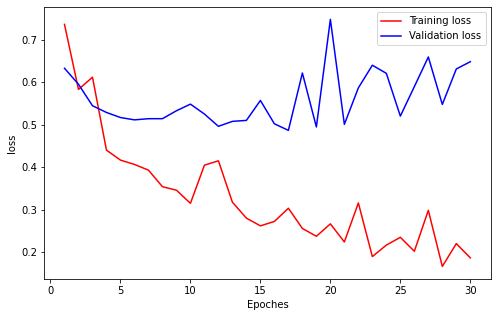

In [18]:
plot_func('loss')

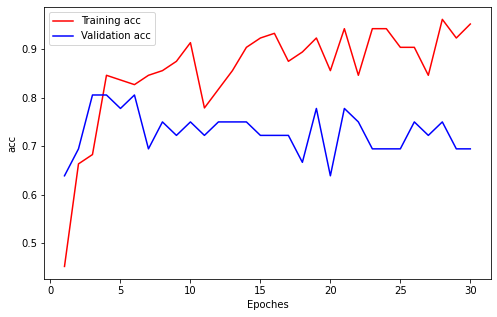

In [19]:
plot_func('acc')

# Fine tuning the model


#### Unlocking the top convolutional block 

We trained previosuly with only top layer removed from VGG16. Here we unlock top base layer from VGG16 and fine tune the model. Doing so we reduce the learning rate from $10^{-4}$ to $10^{-5}$. We train for the 50 epoches. The model surpass the validation accuracy of 97% shortly after 30 epochs. It is not unlikely to improve the model after 50 epochs. But I am happy with this for now. The future plan is to check with other pre-trained model rather. 

In [20]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    else:
        set_trainable = False
    
model.compile(loss='binary_crossentropy', 
             optimizer=optimizers.RMSprop(lr=1e-5), 
             metrics=['acc'])

#### Fitting the model 

In [21]:
history = model.fit_generator(train_generator, epochs=50, 
                             validation_data=test_generator)

Epoch 1/50
4/4 [==============================] - 29s 7s/step - loss: 0.4218 - acc: 0.8173 - val_loss: 0.6856 - val_acc: 0.7222
Epoch 2/50
4/4 [==============================] - 27s 6s/step - loss: 0.1593 - acc: 0.9327 - val_loss: 0.5210 - val_acc: 0.7500
Epoch 3/50
4/4 [==============================] - 28s 7s/step - loss: 0.0862 - acc: 0.9904 - val_loss: 0.5361 - val_acc: 0.8056
Epoch 4/50
4/4 [==============================] - 27s 7s/step - loss: 0.0614 - acc: 1.0000 - val_loss: 0.5033 - val_acc: 0.8333
Epoch 5/50
4/4 [==============================] - 27s 7s/step - loss: 0.1000 - acc: 0.9615 - val_loss: 0.7072 - val_acc: 0.7778
Epoch 6/50
4/4 [==============================] - 27s 7s/step - loss: 0.0780 - acc: 0.9712 - val_loss: 0.4830 - val_acc: 0.8333
Epoch 7/50
4/4 [==============================] - 28s 7s/step - loss: 0.0853 - acc: 0.9712 - val_loss: 0.6041 - val_acc: 0.8333
Epoch 8/50
4/4 [==============================] - 27s 7s/step - loss: 0.0738 - acc: 0.9712 - val_loss: 0

In [22]:
model.save('VGG16_fine_tuned.h5')

#### Visualization of fine tuning process

In [23]:
hist_dict = history.history

training_accuracy = hist_dict['acc']
validation_accuracy = hist_dict['val_acc']

training_loss = hist_dict['loss']
validation_loss = hist_dict['val_loss']

epoches = range(1, 1 + len(training_accuracy))

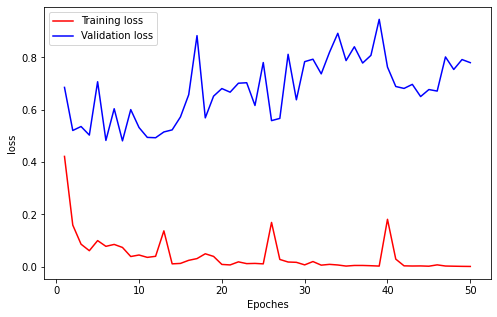

In [24]:
plot_func('loss')

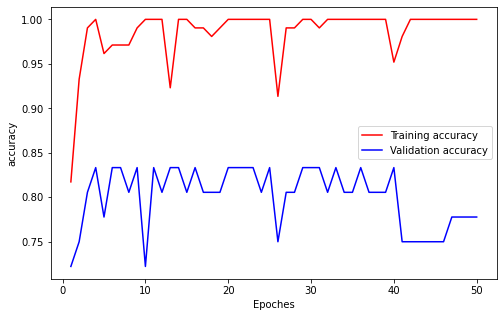

In [25]:
plot_func('accuracy')

# Error Analysis

In this section we analyze the error of the model, i.e. mis-classified images. We first see few examples of the correctly classified images. Then we visualize the confusion matrix. And finally, we see separately fire images classified as non-fire and non-fire images classified as fire.  

In [26]:
# Loading the saved model 
model = load_model('VGG16_fine_tuned.h5')

#### Getting the labels and predictions 

In [27]:
# taking first batch from the generator 
img, label = test_generator[0] 

# Predicting the images from the first batch 
pred = np.round(model.predict(img)).flatten()

In [28]:
len(img)

32

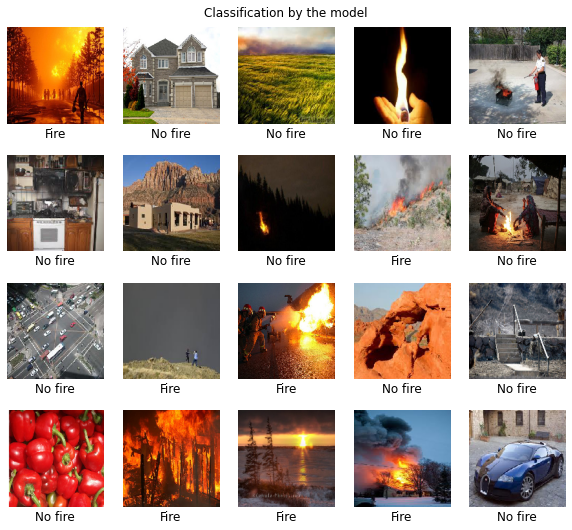

In [29]:
# Numeric to semantic labels 
label_dict = {1.0: 'No fire', 0.0: 'Fire'}

# Generating collage of plots 
fig = plt.figure(figsize=(10, 9))
plt.title('Classification by the model')
plt.axis('off')

for i, img_i in enumerate(img[:20]):
    ax = fig.add_subplot(4, 5, i+1)
    plt.axis('off')
    plt.title(label_dict[pred[i]], y=-0.2)
    ax.imshow(img_i)

#### Extracting misclassified images

In [30]:
# Lists for missed fire images and missed non-fire images
msd_fire = []
msd_nofire = []

# Iterating through all 
for j in range(1):
    print(j)
    print(test_generator[j] )
    img, label = test_generator[j] 
    pred = np.round(model.predict(img)).flatten()
    bool_list = label == pred

    # bool_list is False when there is misclassification 
    for i, e in enumerate(bool_list):
        if e == False:
            
            # separating labels (fire and non-fire)
            if label[i] == 0:
                msd_fire.append(img[i])
            else:
                msd_nofire.append(img[i])

0
(array([[[[0.5176471 , 0.20784315, 0.09019608],
         [0.43529415, 0.0509804 , 0.        ],
         [0.6666667 , 0.21568629, 0.04313726],
         ...,
         [0.9686275 , 0.654902  , 0.10980393],
         [0.8313726 , 0.427451  , 0.        ],
         [1.        , 0.6117647 , 0.16470589]],

        [[0.49803925, 0.15686275, 0.03921569],
         [0.30980393, 0.07843138, 0.0627451 ],
         [0.3372549 , 0.0509804 , 0.        ],
         ...,
         [0.9921569 , 0.7058824 , 0.16078432],
         [0.9921569 , 0.6117647 , 0.15294118],
         [1.        , 0.6666667 , 0.15686275]],

        [[0.454902  , 0.1254902 , 0.02352941],
         [0.17254902, 0.01176471, 0.03529412],
         [0.20000002, 0.01568628, 0.        ],
         ...,
         [0.97647065, 0.68235296, 0.1137255 ],
         [0.98823535, 0.63529414, 0.10196079],
         [0.9803922 , 0.627451  , 0.08627451]],

        ...,

        [[0.03137255, 0.01176471, 0.        ],
         [0.03921569, 0.01176471, 0.      

#### Confusion matrix

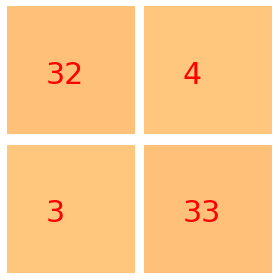

In [31]:
# total number of sample in test set in each class 
n_class = 36

# number of misclassified fire and non-fire images 
nm_fire, nm_nofire = len(msd_fire), len(msd_nofire)

# confusion matrix (flattened)
conf_mat = [n_class-nm_fire, nm_fire, nm_nofire, n_class-nm_nofire]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

#### Showing mis-classified fire images 


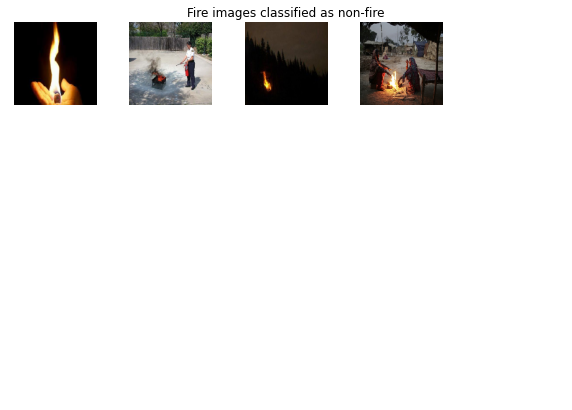

In [32]:
fig = plt.figure(figsize=(10, 7))
plt.title('Fire images classified as non-fire')
plt.axis('off')
for i, img_i in enumerate(msd_fire):        
    ax = fig.add_subplot(4, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

Some of the misclassified figure have fire but that is too small. So even human observer is easy to confuse with them. Though some of the big explicit fire images are misclassified too. May be that is painting of fire but not the picture. Misclassified fire images are mostly bonfire, stove fire, fire tourch, kitchen fire etc. This is not big surprise because there were not enough fire sample in training set in that categories.  

#### Showing mis-classified non-fire images. 

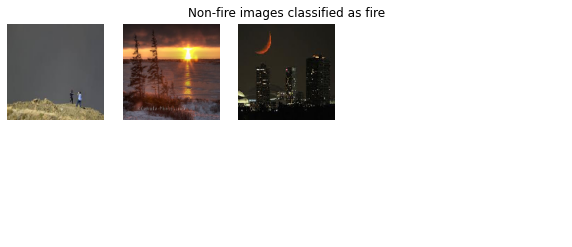

In [33]:
fig = plt.figure(figsize=(10, 4))
plt.title('Non-fire images classified as fire')
plt.axis('off')
for i, img_i in enumerate(msd_nofire):        
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(img_i)
    ax.axis('off')

Looking at this mis-classified set some of the picture actually seem to have fire. So, the problem is about the mis-labeling. Others don't have fire but have artificial red light or are picture with hue of dawn and dusk almost appearing as fire. 

Overall the model has done very good job separating those images with solid 97% accuracy in out of sample images. 

In [34]:
import tensorflow as tf
from tensorflow import keras
image_size = (150, 150)

In [40]:
def cassifiy_func(path):
    
    '''
    This function cassifiy the dataset which model prepare for use with it 
    '''
    files = os.listdir(path)
    plt.figure(figsize=(20,20))
    for i in range(16):
        img = keras.preprocessing.image.load_img(os.path.join(path,files[i]), target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # Create batch axis
        predictions = model.predict(img_array)
        score = predictions[0]
        ax =  plt.subplot(4,4,i+1)
        ax.axis('off')
        ax.set_title("%.2f percent fire and %.2f percent nofire."
            % (100 * (1 - score), 100 * score))
        plt.imshow(img)
    plt.axis('off')
    plt.suptitle("This test on blend dataset.")    
    plt.show()

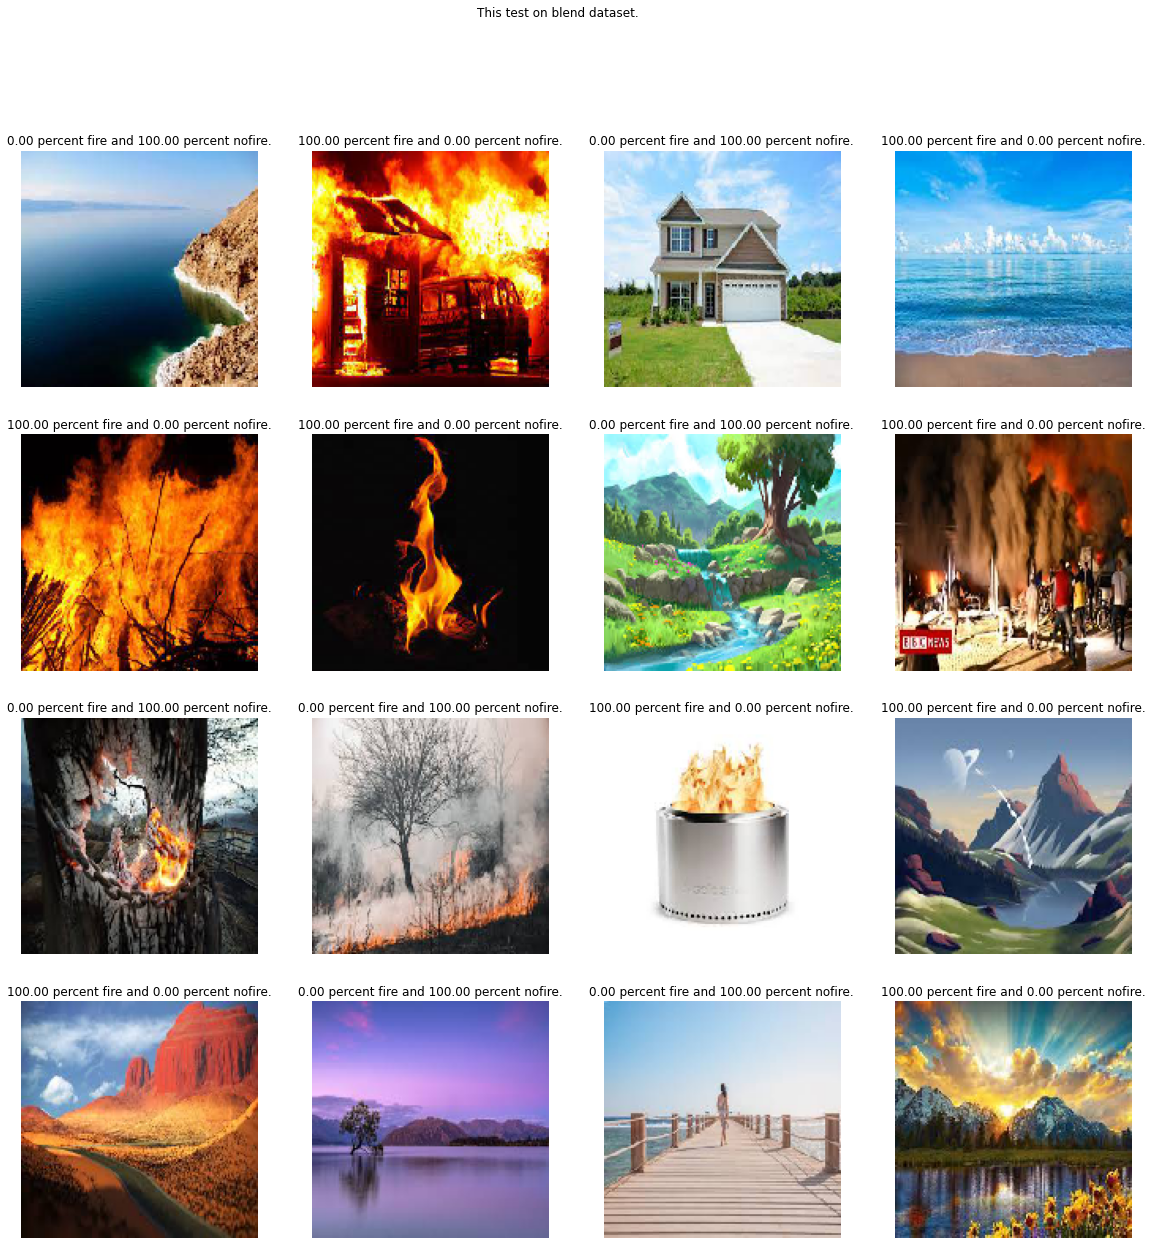

In [41]:
new_path = 'C:/Users/decim/OneDrive/Desktop/Fire Detection Model master/A/Dataset/new'
cassifiy_func(new_path)

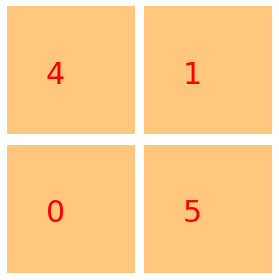

In [42]:
# confusion matrix (flattened)
conf_mat = [4,1,0,5]

# visualization of confusion matrix 
fig = plt.figure(figsize=(4, 4))
for i, j in enumerate(conf_mat):
    ax = fig.add_subplot(2, 2, i+1)
    ax.imshow([[j]], vmin=0, vmax=1000, cmap='copper_r')
    ax.text(-0.2, 0.1, j, c='r', fontsize=30)
    ax.axis('off')

# bringing blocks tighter 
fig.tight_layout()
fig.show()

In [38]:
TN = conf_mat[0]
TP = conf_mat[1]
FP = conf_mat[2]
FN = conf_mat[3]
sen = 100*TP/(TP+TN)
spec = 100*TN/(TN+FP)
acc = 100*(TP+TN)/(TP+FP+TN+FN)
mcc = (TP*TN - FP*FN)/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

In [39]:
mcc

0.2721655269759087